### This code has a custom callback that is a combination of early stopping, reduce learning rate on plateau 
### and model checkpoint. It has the following input parameters
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
            factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0 )] 
The callback initially monitor the training accuracy. If the training accuracy fails to improve for 'patience'
number of epochs the learning rate is reduced by to the value new lr= current lr * factor' Once the training
accuracy exceeds the level set by the parameter 'threshold' the callback switches to monitor validation loss.
Again if validation loss fails to decrease for 'patience' number of consecutive epochs the learning rate is
reduced as discribed above. Parameter 'stop_patience' is used to set how many consecutive adjustments of the
learning rate can occur without metric improvement before training is terminated.Parameter model is the model
you created with model.compile in your code. Parameter model_name is a string for the name of your model for
example 'Mobilenet'. Parameter 'dwell' is a boolean. If set to True then if the current epoch resulted in no
improvement of the metric, the models weights are set back to the weights of the model in the previous epoch 
and the learning rate is reduced. Logic here is if the metric did not improve you moved to a location in N space
(N being the number of trainable parameters in the model) that is not as favorable as the position you were in
for the previous epoch. So why stay in this less favorable location, rather go back to the previous location by setting the model weights back to those of the previous epoch. Parameter 'Freeze' is just for display purpose. See the
image below. It simply tells the callback to print 'training all layers' Batches is an interger that is the
value of the number of training steps. For example if your traning set has 10000 samples and you set the batch
size to 100 than set batch= samples/batch_size. In the code below jog down to where the callback prints out
the training data to see how the information is displayed. Not batch count data disappears when training is completed.
you see the running batch count and total number of batches to be processed per epoch. This is a substitute for
the model.fit progress bar. In model.fit I set verbose=0 to stop the model,fit printout and let the callback
print the result for each epoch as shown in the image below.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

### Unused code experiment with masking
imgpath=r'../input/ham1000-segmentation-and-classification/images/ISIC_0024306.jpg'
maskpath=r'../input/ham1000-segmentation-and-classification/masks/ISIC_0024306_segmentation.png'

plt.figure(figsize=(10, 20))
plt.subplot(5, 2,  1)
img=plt.imread(imgpath)
plt.title('input image')
plt.imshow(img/255)
mask=plt.imread(maskpath)
maxpix=np.max(mask)
print ('mask maximum pixel value= ',maxpix)
plt.subplot(5, 2,  2)
plt.title('mask')
plt.imshow(mask)
b, g, r = cv2.split(img)
print ('blue channel max pixel value= ', np.max(b))
plt.subplot(5,2,3)
plt.title('blue channel')
plt.imshow(b)
plt.subplot(5,2,4)
plt.title('bm=blue * mask')
bm=b*mask
print('blue channel masked max pixel value= ', np.max(bm))
plt.imshow(bm)
gm=g*mask
plt.subplot(5, 2,  5)
plt.title('green channel')
plt.imshow(g)
plt.subplot(5, 2,  6)
plt.title('gm=green * mask')
plt.imshow(gm)
rm=g * mask
plt.subplot(5,2,7)
plt.title('red channel')
plt.imshow(r)
plt.subplot(5,2,8)
plt.title('rm=red * mask')
plt.imshow(rm)
masked_img= cv2.merge([bm, gm, rm])/255
print('max pixel value of result= ', np.max(masked_img))
plt.subplot(5,2,9)
plt.title('merged(bm,gm,rm)')
plt.imshow(masked_img)
plt.show()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
from tensorflow.keras import callbacks    

### input an image and get the shape

(450, 600, 3)


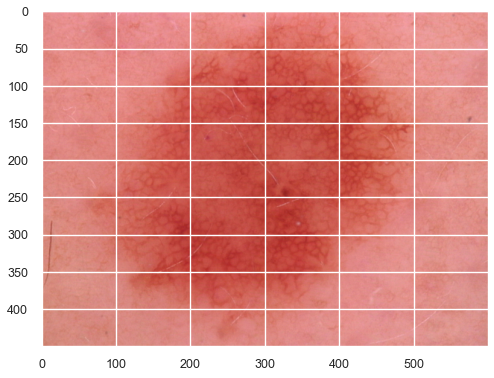

In [22]:
fpath= r'C:\Users\lucas\Documents\Projeto TEEE\images\ISIC_0024316.jpg'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

### read in the csv file

In [5]:
df=pd.read_csv(r'C:\Users\lucas\Documents\Projeto TEEE\Skin-Desease-Identification\GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


## Warning the column image does NOT include the extension '.jpg' so to work need to modify the image column

In [6]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


### one hot encoding caused problem when trying to create ImageDataGenerator.flow_from_dataframe even with  class_mode='raw'
as a work around create a new column in df labels that contains the string version of the label, like "MEL" , "NV" etc
then you can use this as y_col=labels with class_mode='categorical

In [7]:
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df)): 
    row = list(df.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df['teste']= label_list
df=df.drop(labels, axis=1)
print (df.head())
print (df['teste'].value_counts())

              image teste
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: teste, dtype: int64


In [8]:
apagado = 0
for i in range (len(df)):
    row = list(df.iloc[i-apagado])
    if row[1] == 'BCC' or row[1] == 'AKIEC' or  row[1] == 'VASC' or row[1] == 'DF':
        df = df.drop(i, axis = 0)
        apagado += 1
print (df.head())


              image teste
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


In [9]:
print (df['teste'].value_counts())

NV     6705
MEL    1113
BKL    1099
Name: teste, dtype: int64


In [10]:
print ('original number of classes: ', len(df['teste'].unique()))     
size=1100 # set number of samples for each class
samples=[]
group=df.groupby('teste')
for teste in df['teste'].unique():
    Lgroup=group.get_group(teste)
    count=int(Lgroup['teste'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 
df=pd.concat(samples, axis=0).reset_index(drop=True)
print (len(df))
print ('final number of classes: ', len(df['teste'].unique()))       
print (df['teste'].value_counts())  

original number of classes:  3
3299
final number of classes:  3
NV     1100
MEL    1100
BKL    1099
Name: teste, dtype: int64


### split df into train, test and valid dataframes

In [24]:
train_split=.9 # set this to the percentof the data you want to use for training
train_df, test_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=157)
print(' train_df length: ', len(train_df), '  test_df length: ', len(test_df))  
print (train_df.head())
print (train_df['teste'].value_counts())

 train_df length:  2969   test_df length:  330
                 image teste
941   ISIC_0029550.jpg    NV
433   ISIC_0026425.jpg    NV
2251  ISIC_0031766.jpg   BKL
1637  ISIC_0033278.jpg   MEL
467   ISIC_0031313.jpg    NV
NV     998
BKL    996
MEL    975
Name: teste, dtype: int64


### create train, test, valid  generators

In [25]:
sdir=r'C:\Users\lucas\Documents\Projeto TEEE\images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='Identificador' # part of the name of the saved model
height=224  # image height
width=224   # image width
channels=3  # number of coloor channels
#batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)
# code below determines test generator batch size and steps so that test_batch_size X test_steps = number of test samples
# ensures that for predictions you go through the test set exactly once
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
print ( 'test batch size: ' ,test_batch_size)
#
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet
train_gen=gen.flow_from_dataframe( train_df, sdir, x_col='image', y_col='teste', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True)
test_gen=gen.flow_from_dataframe( test_df, sdir, x_col='image', y_col='teste', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True)


classes=list(train_gen.class_indices.keys())

class_count=len(classes)



test batch size:  66
Found 2969 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.


### create function to show some image examples

In [26]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

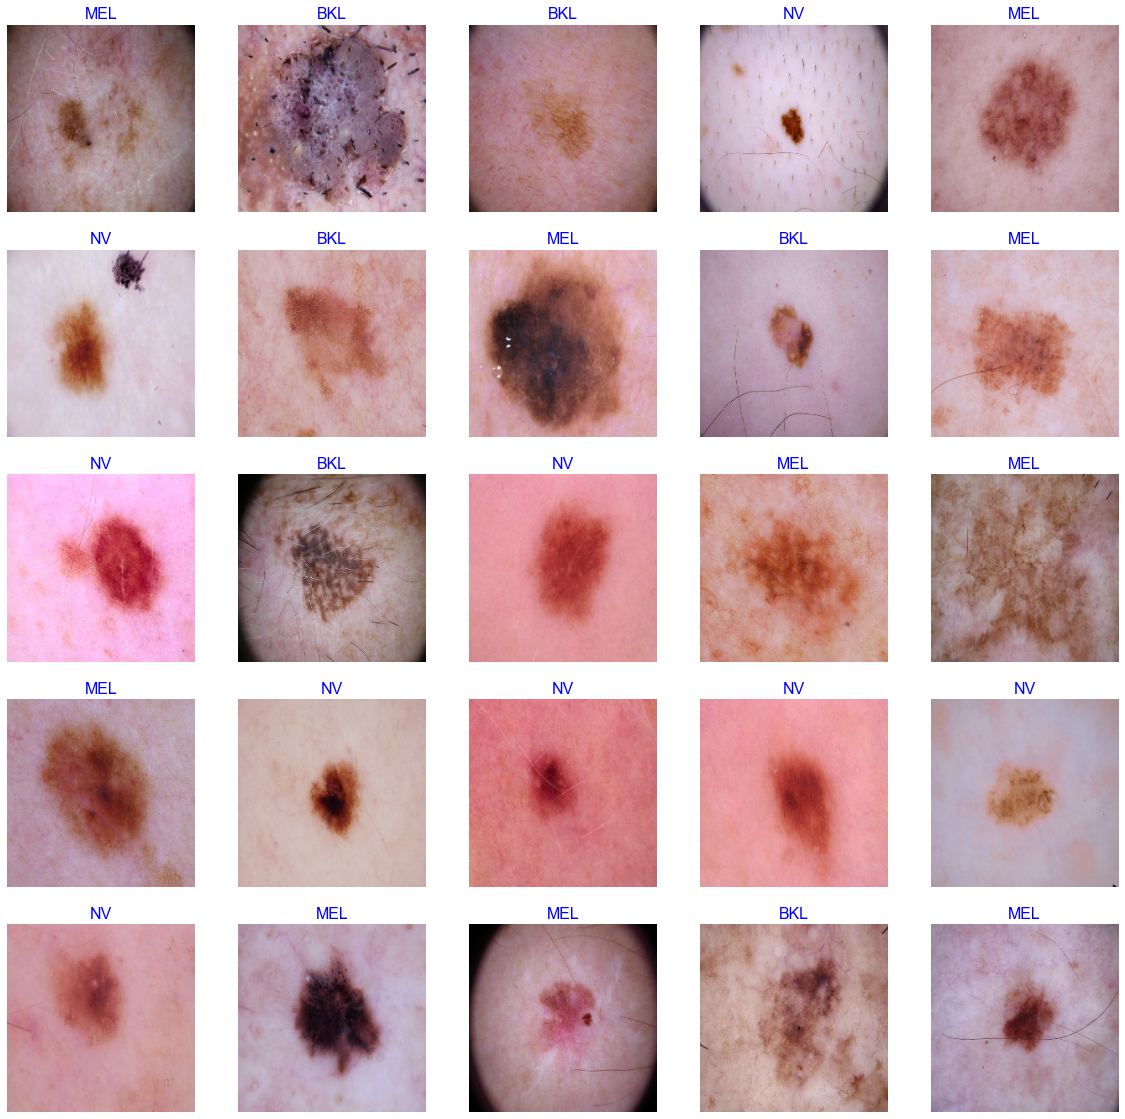

In [27]:
show_image_samples(train_gen)

### define function to print text in RGB foreground and background colors

In [28]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### create the model

In [30]:
model_name='EfficientNetB5'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

### create a subclass of callbacks to control learning rate and print training results for each epoch

### Instantiate the callback and train the model

### define function to plot the training data

In [32]:
model_checkpoint = callbacks.ModelCheckpoint("model.hdf5", monitor = "val_accuracy", save_best_only = True, verbose = 1)

In [33]:
epochs =20
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model

history=model.fit(x=train_gen, batch_size=10,  epochs=epochs, verbose = 1 , callbacks=[model_checkpoint],  validation_data=test_gen,
               validation_steps=None,  shuffle=True,  initial_epoch=0)

Epoch 1/20
40/93 [===========>..................] - ETA: 5:16 - loss: 8.7253 - accuracy: 0.4786

In [42]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define function to generate the confusion matrix and classification report

In [43]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

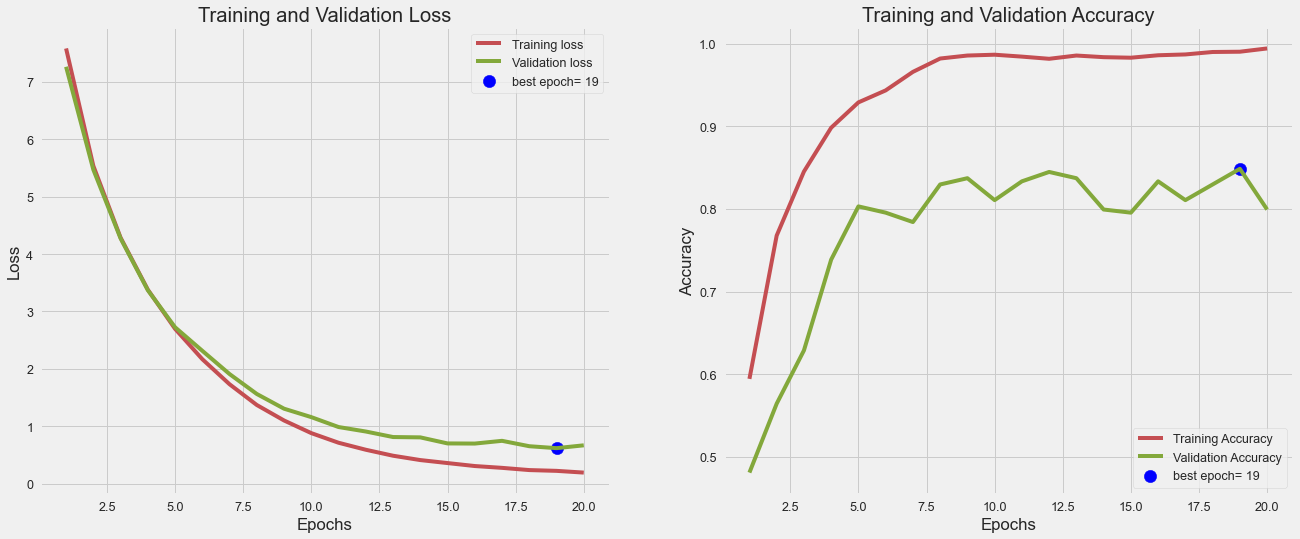

9/9 [==============================] - 10s 1s/step - loss: 0.6678 - accuracy: 0.7992
accuracy on the test set is 79.92 %



In [47]:
tr_plot(history,0)
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

### make predictions on test set and generate confusion matrix and classification report

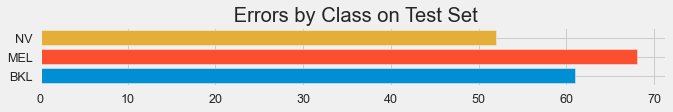

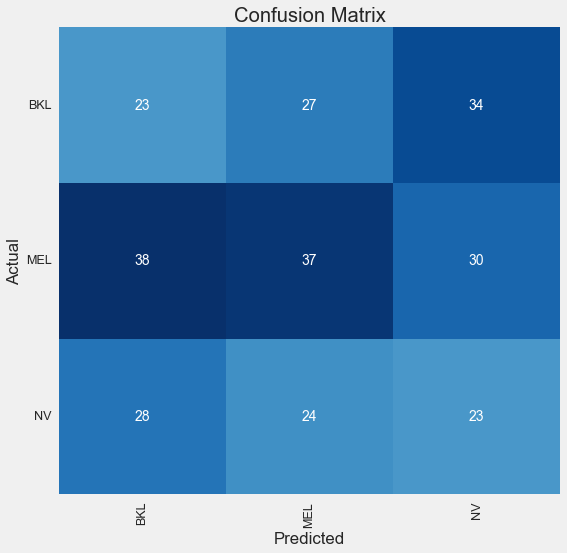

Classification Report:
----------------------
               precision    recall  f1-score   support

         BKL       0.26      0.27      0.27        84
         MEL       0.42      0.35      0.38       105
          NV       0.26      0.31      0.28        75

    accuracy                           0.31       264
   macro avg       0.31      0.31      0.31       264
weighted avg       0.32      0.31      0.32       264



In [48]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  